In [ ]:
# Cell: Install Dependencies and Import Libraries
# PyTorch and most libs are pre-installed in Colab, but install kaggle for dataset download

!pip install kaggle -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models
import pandas as pd
from PIL import Image
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import label_binarize

In [ ]:
# Cell 2: Download and Prepare Dataset (No Google Drive)
dataset_path = '/content/HAM10000'

# Upload kaggle.json if needed
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("Please upload kaggle.json")
    files.upload()  # Upload kaggle.json (only manual input)
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

# Download dataset if not present
if not os.path.exists(f'{dataset_path}/HAM10000_metadata.csv'):
    print("Downloading dataset...")
    !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
    print("Unzipping dataset...")
    !unzip -q skin-cancer-mnist-ham10000.zip -d {dataset_path}
else:
    print("Dataset already downloaded.")

# Move images if not already done
if not os.path.exists(f'{dataset_path}/images/') or len(os.listdir(f'{dataset_path}/images/')) < 10000:
    print("Moving images...")
    !mkdir -p {dataset_path}/images/
    !mv {dataset_path}/ham10000_images_part_1/* {dataset_path}/images/
    !mv {dataset_path}/ham10000_images_part_2/* {dataset_path}/images/
else:
    print("Images already moved.")

# Verify
print("Metadata file:", os.path.exists(f'{dataset_path}/HAM10000_metadata.csv'))
print("Image count:", len(os.listdir(f'{dataset_path}/images/')))

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
 99% 5.16G/5.20G [02:26<00:02, 15.9MB/s]
100% 5.20G/5.20G [02:26<00:00, 38.1MB/s]
Unzipping dataset...
Moving images...
Metadata file: True
Image count: 10015


In [ ]:
# Cell: Custom Dataset Class

class SkinCancerDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.metadata = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # Handle missing ages (fill with mean)
        self.metadata['age'].fillna(self.metadata['age'].mean(), inplace=True)

        # Encode categorical variables
        self.sex_encoder = LabelEncoder()
        self.metadata['sex_encoded'] = self.sex_encoder.fit_transform(self.metadata['sex'])

        self.loc_encoder = LabelEncoder()
        self.metadata['localization_encoded'] = self.loc_encoder.fit_transform(self.metadata['localization'])

        # Normalize age (0-100 scale)
        self.metadata['age_normalized'] = self.metadata['age'] / 100.0

        # Encode labels
        self.label_encoder = LabelEncoder()
        self.metadata['label'] = self.label_encoder.fit_transform(self.metadata['dx'])

        self.num_classes = len(self.label_encoder.classes_)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.metadata.iloc[idx]['image_id'] + '.jpg')
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        age = torch.tensor([self.metadata.iloc[idx]['age_normalized']], dtype=torch.float32)
        sex = torch.tensor([self.metadata.iloc[idx]['sex_encoded']], dtype=torch.int64)
        loc = torch.tensor([self.metadata.iloc[idx]['localization_encoded']], dtype=torch.int64)

        # One-hot encode sex and localization
        sex_onehot = torch.nn.functional.one_hot(sex, num_classes=len(self.sex_encoder.classes_)).float()
        loc_onehot = torch.nn.functional.one_hot(loc, num_classes=len(self.loc_encoder.classes_)).float()

        metadata = torch.cat((age, sex_onehot.squeeze(0), loc_onehot.squeeze(0)))

        label = torch.tensor(self.metadata.iloc[idx]['label'], dtype=torch.long)

        return image, metadata, label

In [ ]:
# Cell: Data Transformations and Loaders

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load full dataset
full_dataset = SkinCancerDataset(
    csv_file='./HAM10000/HAM10000_metadata.csv',
    img_dir='./HAM10000/images/',
    transform=train_transform
)

# Split into train, val, test (70/15/15)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Apply val_transform to val and test
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)  # num_workers=2 for Colab
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

/tmp/ipython-input-1495434625.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.metadata['age'].fillna(self.metadata['age'].mean(), inplace=True)


In [ ]:
# Cell: Multimodal Model Definition

class MultimodalResNet(nn.Module):
    def __init__(self, num_classes, metadata_size):
        super(MultimodalResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # Get 512 features

        # MLP for metadata
        self.metadata_mlp = nn.Sequential(
            nn.Linear(metadata_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # Classifier
        self.classifier = nn.Linear(512 + 64, num_classes)

    def forward(self, image, metadata):
        img_features = self.resnet(image)
        meta_features = self.metadata_mlp(metadata)
        combined = torch.cat((img_features, meta_features), dim=1)
        return self.classifier(combined)

In [ ]:
# Cell: Model Instantiation and Training

# Get sizes
metadata_size = 1 + len(full_dataset.sex_encoder.classes_) + len(full_dataset.loc_encoder.classes_)
num_classes = full_dataset.num_classes

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model
model = MultimodalResNet(num_classes, metadata_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, metadata, labels in train_loader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, metadata)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, metadata, labels in val_loader:
                images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
                outputs = model(images, metadata)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Validation Accuracy: {100 * correct / total:.2f}%')

# Train
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Save model
torch.save(model.state_dict(), 'model.pth')

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 211MB/s]


Epoch [1/10], Loss: 0.7899
Validation Accuracy: 73.97%
Epoch [2/10], Loss: 0.6477
Validation Accuracy: 77.10%
Epoch [3/10], Loss: 0.5711
Validation Accuracy: 72.44%
Epoch [4/10], Loss: 0.5421
Validation Accuracy: 77.30%
Epoch [5/10], Loss: 0.5059
Validation Accuracy: 76.63%
Epoch [6/10], Loss: 0.4603
Validation Accuracy: 79.83%
Epoch [7/10], Loss: 0.3926
Validation Accuracy: 79.16%
Epoch [8/10], Loss: 0.3575
Validation Accuracy: 78.10%
Epoch [9/10], Loss: 0.2710
Validation Accuracy: 80.29%
Epoch [10/10], Loss: 0.2400
Validation Accuracy: 80.29%


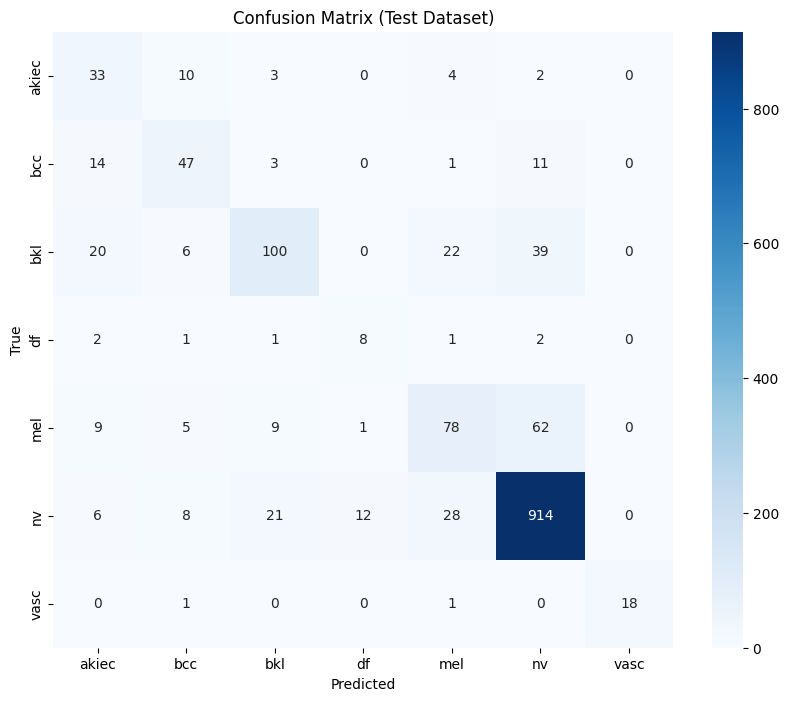

F1 Score (Macro, Test): 0.6474
AUC (Macro, OVR, Test): 0.9522


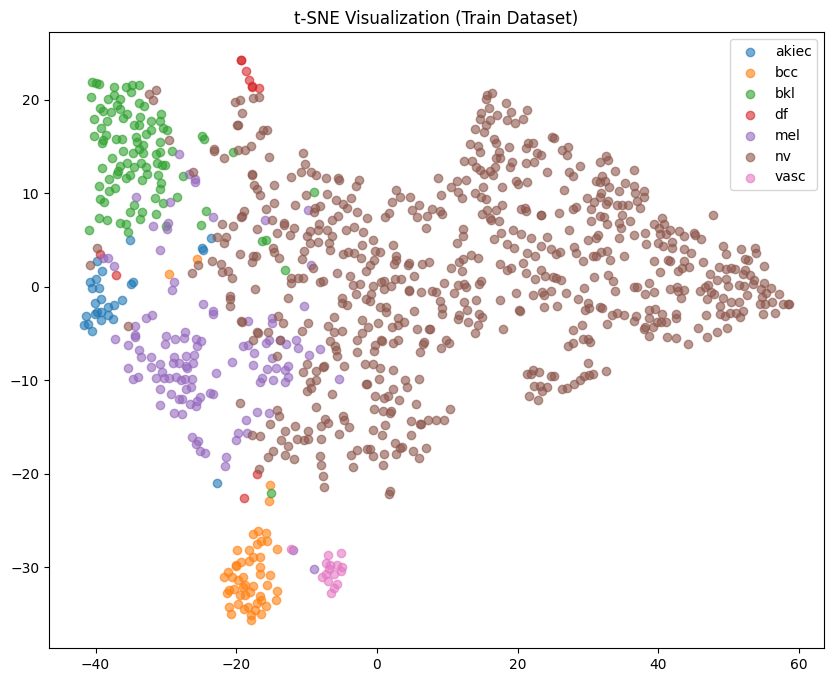

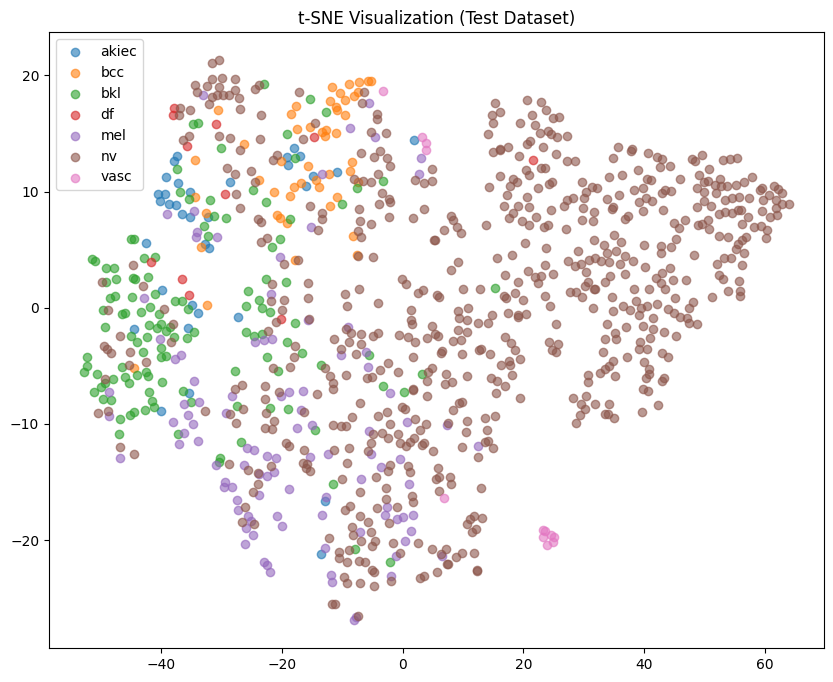

In [ ]:
# Cell: Testing and Evaluation

# Load model if needed (uncomment if restarting)
# model = MultimodalResNet(num_classes=full_dataset.num_classes, metadata_size=metadata_size).to(device)
# model.load_state_dict(torch.load('model.pth'))

# Function to get predictions and features
def get_predictions_and_features(model, loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    all_features = []

    with torch.no_grad():
        for images, metadata, labels in loader:
            images, metadata = images.to(device), metadata.to(device)
            outputs = model(images, metadata)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            _, preds = torch.max(outputs, 1)

            img_features = model.resnet(images)
            meta_features = model.metadata_mlp(metadata)
            combined = torch.cat((img_features, meta_features), dim=1).cpu().numpy()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs)
            all_features.extend(combined)

    return np.array(all_labels), np.array(all_preds), np.array(all_probs), np.array(all_features)

# Get test data
test_true_labels, test_pred_labels, test_probs, test_features = get_predictions_and_features(model, test_loader, device)

# Confusion Matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)
class_names = full_dataset.label_encoder.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Dataset)')
plt.show()

# F1 Score
f1 = f1_score(test_true_labels, test_pred_labels, average='macro')
print(f'F1 Score (Macro, Test): {f1:.4f}')

# AUC
binarized_labels = label_binarize(test_true_labels, classes=range(num_classes))
auc = roc_auc_score(binarized_labels, test_probs, multi_class='ovr', average='macro')
print(f'AUC (Macro, OVR, Test): {auc:.4f}')

# Get train features for t-SNE
train_true_labels, _, _, train_features = get_predictions_and_features(model, train_loader, device)

# Subsample (optional, for speed)
subsample_size = 1000
train_features = train_features[:subsample_size]
train_true_labels = train_true_labels[:subsample_size]
test_features = test_features[:subsample_size]
test_true_labels = test_true_labels[:subsample_size]

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
train_tsne = tsne.fit_transform(train_features)
test_tsne = tsne.fit_transform(test_features)

# Plot Train t-SNE
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    idx = train_true_labels == i
    plt.scatter(train_tsne[idx, 0], train_tsne[idx, 1], label=class_names[i], alpha=0.6)
plt.legend()
plt.title('t-SNE Visualization (Train Dataset)')
plt.show()

# Plot Test t-SNE
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    idx = test_true_labels == i
    plt.scatter(test_tsne[idx, 0], test_tsne[idx, 1], label=class_names[i], alpha=0.6)
plt.legend()
plt.title('t-SNE Visualization (Test Dataset)')
plt.show()